In [17]:
import os
import numpy as np
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
x_source_red = [-0.5, 0.0, 0.5]
y_source_red = [-0.5, 0.0, 0.5]
ref_data = {}
for f in os.listdir('data'):
    i, j = [int(x) for x in f.split('.txt')[0].split('comsol_')[-1].split('_')]
    data = np.loadtxt(os.path.join('data', f), delimiter=',')
    ref_data[(x_source_red[i], y_source_red[j])] = {
        'x': data[:, 0],
        'y': data[:, 1],
        'u': data[:, 2]
    }
    print(i, j, data.shape)

1 2 (10000, 3)
1 0 (10000, 3)
1 1 (10000, 3)
0 0 (10000, 3)
2 2 (10000, 3)
0 1 (10000, 3)
2 1 (10000, 3)
2 0 (10000, 3)
0 2 (10000, 3)


In [19]:
TRAIN = True
PATH_NAME = "PI_DeepONet_Laplace"
if TRAIN and os.path.exists(PATH_NAME):
    os.system("rm -rf {}".format(PATH_NAME))
os.makedirs(PATH_NAME, exist_ok=True)
EPOCH_MAX = 10000

In [20]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [21]:
SENSOR_SIZE = 1
SOURCE_RADI = 0.1

In [22]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(domain=1000, bc=100),
                       sensor_size = 10,
                       source_radius = 0.1,
                       shuffle = True,
                       domain = dict(x = [-1, 1], y = [-1, 1]),
                       seed=1234):
        # generate data
        self._radius = source_radius
        self._xmin, self._xmax = domain['x']
        self._ymin, self._ymax = domain['y']
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        self._shuffle = shuffle
        self._set_data(sample_size, batch_size)
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._sample_ids)

    def _set_data(self, num_sample, batch_size):
        inputs, targets, sample_weights = [], [], []
        num_source_1d = int(np.sqrt(num_sample+1e-6))
        grid_x = np.linspace(self._xmin, self._xmax, num_source_1d+2)[1:-1] # del boundary nodes
        grid_y = np.linspace(self._ymin, self._ymax, num_source_1d+2)[1:-1] # del boundary nodes
        x_source, y_source = [x.flatten() for x in np.meshgrid(grid_x, grid_y)]
        for xs, ys in zip(x_source, y_source):
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(xs, ys, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)
        # return inputs, targets, sample_weights

    def __generate_batch_data(self, x_source, y_source, batch_size):
        counter = 0

        # sample domain
        x_dom, y_dom = lhs_uniform(2, batch_size['domain'],
                                   [[self._xmin, self._xmax], [self._ymin, self._ymax]])
        ids_dom = np.arange(batch_size['domain'])
        counter += ids_dom.size

        # Sample BC
        # edge 1
        x_bc = np.concatenate(
            [np.linspace(self._xmin, self._xmax, batch_size['bc']),
             np.linspace(self._xmin, self._xmax, batch_size['bc']),
             np.linspace(self._xmin, self._xmin, batch_size['bc']),
             np.linspace(self._xmax, self._xmax, batch_size['bc'])]
        )
        y_bc = np.concatenate(
            [np.linspace(self._ymin, self._ymin, batch_size['bc']),
             np.linspace(self._ymax, self._ymax, batch_size['bc']),
             np.linspace(self._ymin, self._ymax, batch_size['bc']),
             np.linspace(self._ymin, self._ymax, batch_size['bc'])]
        )
        ids_bc = np.arange(batch_size['bc']*4) + counter
        counter += ids_bc.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_dom, x_bc]).reshape(-1,1)
        y_trunk = np.hstack([y_dom, y_bc]).reshape(-1,1)
        
        # branch inputs
        x_branch = np.tile([x_source], (size_sample, 1))
        y_branch = np.tile([y_source], (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        targets, sample_weights = [], []
        for idx in [ids_dom, ids_bc]:
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            targets.append(np.zeros((size_sample, 1)))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, X_coord, Y_coord, sensor_size=10):
        counter = 0

        # sample domain
        # mesh_grid = np.meshgrid(np.linspace(self._xmin,self._xmax,Nx),
        #                         np.linspace(self._ymin,self._ymax,Ny))
        # x_trunk, y_trunk = [x.reshape(-1,1) for x in mesh_grid]
        x_trunk, y_trunk = X_coord.reshape(-1,1), Y_coord.reshape(-1,1)
        size_sample = len(x_trunk)

        # branch inputs
        x_branch = np.tile([Xs], (size_sample, 1))
        y_branch = np.tile([Ys], (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        
        return inputs


In [23]:
sn.reset_session()
sn.set_random_seed(1234)

In [24]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=1, embedding_size=20, branch_layers=7*[20], trunk_layers=7*[20], actf='tanh'):
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.branch_inputs = [sn.Variable('xb', units=sensor_size),
                              sn.Variable('yb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, 'linear')
        
        self.output = sn.rename(sn.dot(self.branch, self.trunk), 'u')
        
        d2u_dx2 = sn.diff(self.output, self.trunk_inputs[0], order=2)
        d2u_dy2 = sn.diff(self.output, self.trunk_inputs[1], order=2)
        
        source = sn.exp(-((self.trunk_inputs[0] - self.branch_inputs[0])**2 +
                          (self.trunk_inputs[1] - self.branch_inputs[1])**2) / SOURCE_RADI)
        eikonal = sn.rename(d2u_dx2 + d2u_dy2 + source, 'laplace')
        bc = sn.rename(self.output*1.0, 'source')

        self.losses = [eikonal, bc]

        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs, self.losses, optimizer='adam')
    
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=5e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            # adaptive_weights=dict(method="GN", freq=100, alpha=1.),
            target_weights=[0.2, 1],
            save_weights={"path": os.path.join(PATH_NAME, "weights"), "freq": 100}
        )
        return self.history

    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [25]:
dg = DataGenerator(
    sample_size=25,
    batch_size={'domain': 2000, 'bc':100},
    sensor_size=SENSOR_SIZE,
    source_radius=SOURCE_RADI
)

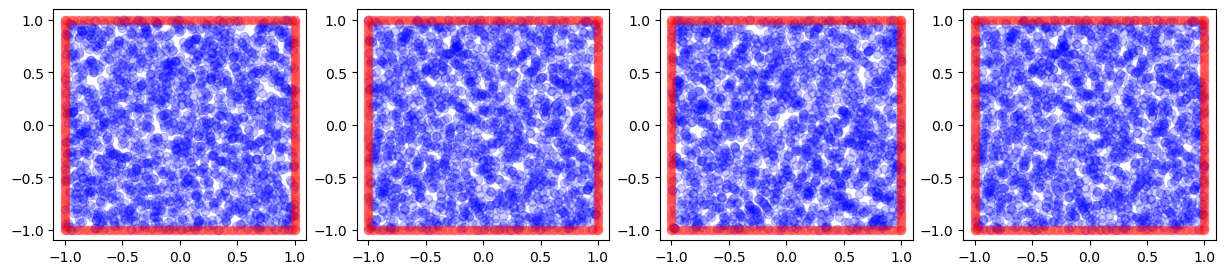

In [26]:

from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, x_branch, y_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [27]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=50,
    branch_layers=5*[50],
    trunk_layers=5*[50]
)

In [28]:
DON.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xb (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 yb (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 concat_3 (Concatenate)         (None, 2)            0           ['xb[0][0]',                     
                                                                  'yb[0][0]']                     
                                                                                                  
 D50b_15 (Dense)                (None, 50)           150         ['concat_3[0][0]']           

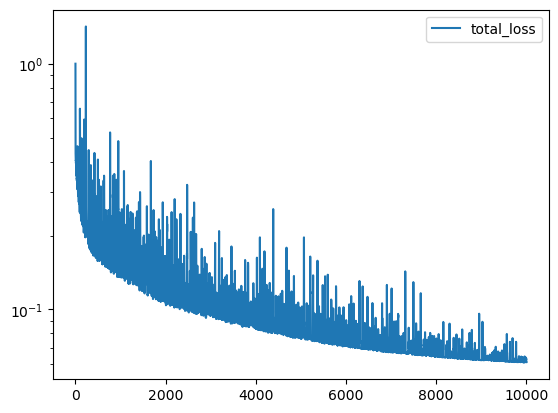

In [29]:
if TRAIN:
    DON.train(dg, epochs=EPOCH_MAX, verbose=0)
    path = os.path.join(PATH_NAME, 'loss_history.csv')
    pd.DataFrame.from_dict(DON.history.history).to_csv(path, index=False)
    DON.plot_loss()
else:
    DON.model.load_weights(os.path.join(PATH_NAME, "weights-end.h5"))

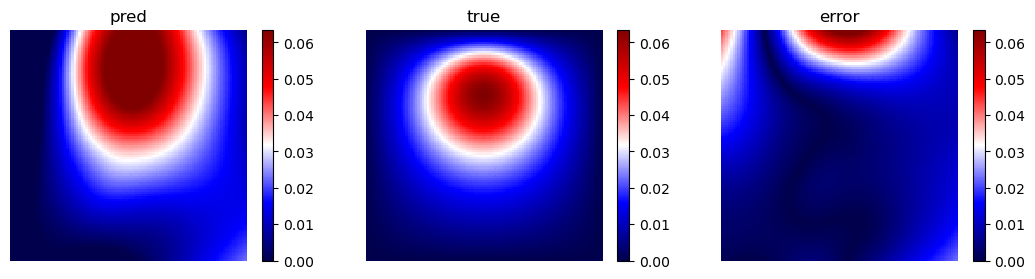

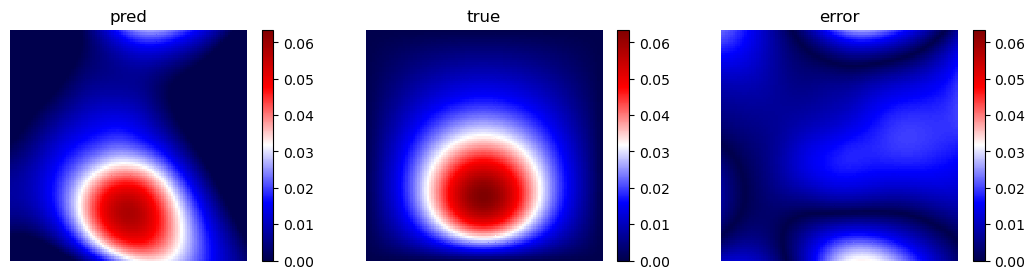

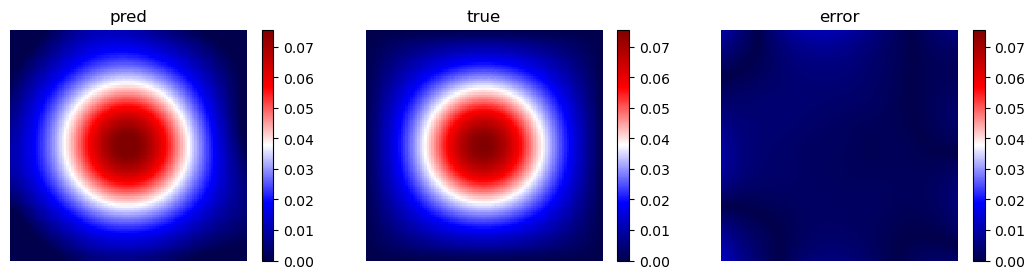

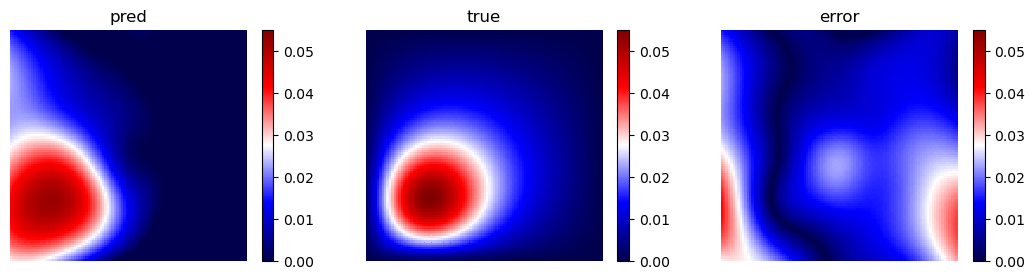

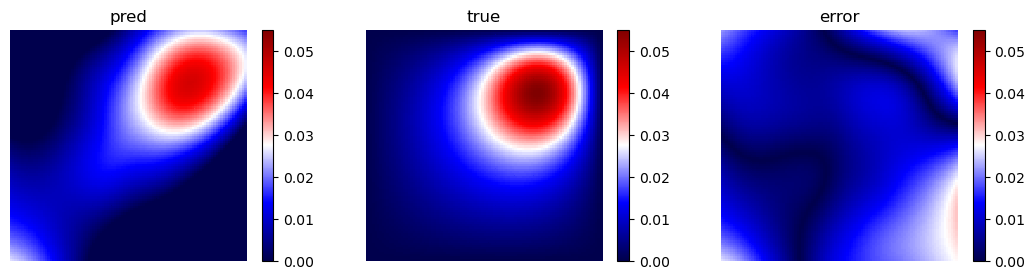

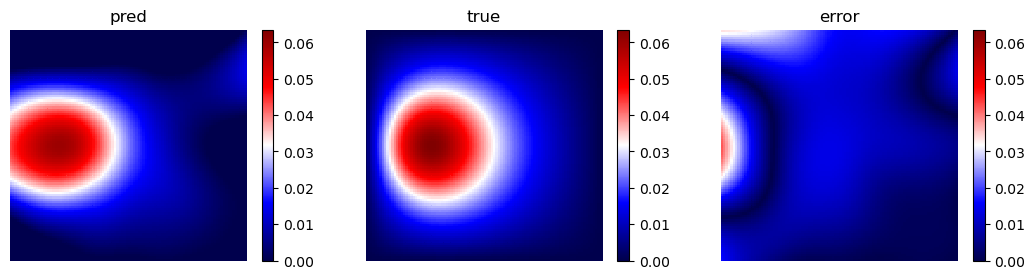

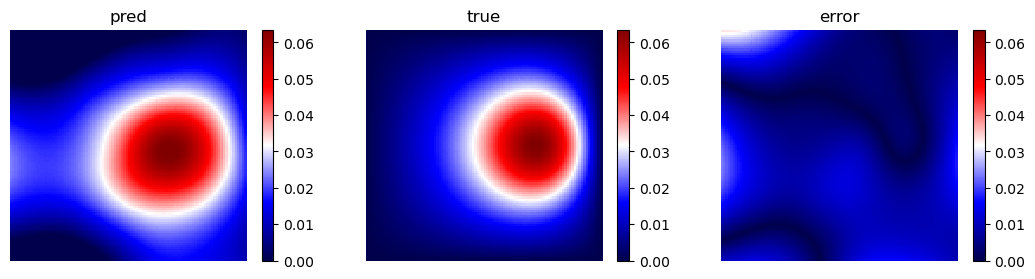

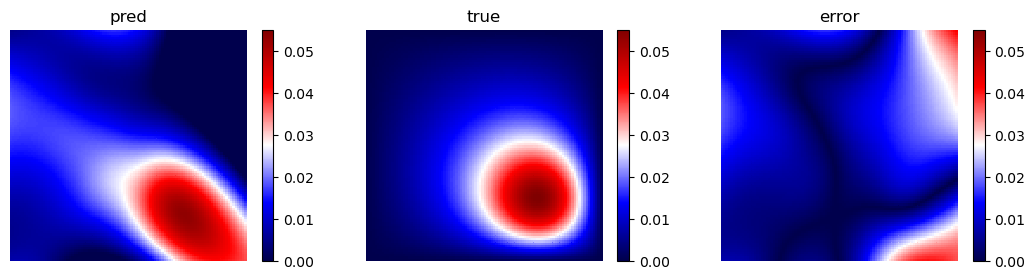

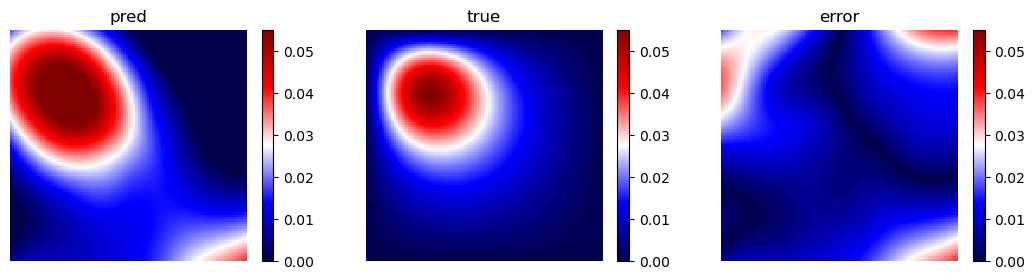

In [30]:

mse_error = []

for key in ref_data:
    Xs, Ys = key
    X_coord, Y_coord = ref_data[key]['x'], ref_data[key]['y']

    r = dg._radius
    test_data = dg.generate_test_data(Xs, Ys, X_coord, Y_coord, sensor_size=SENSOR_SIZE)
    
    Nx = Ny = int(np.sqrt(len(X_coord)))
    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    exact = ref_data[key]['u'].reshape(Nx, Ny)
    mse_error.append(np.mean((pred - exact)**2))
    
    vmin, vmax = 0., np.max(exact)
    fig, ax = plt.subplots(1, 3, figsize=(13, 3))
    ax0 = ax[0].pcolor(x_test, y_test, pred, cmap='seismic', vmin=vmin, vmax=vmax)
    ax[0].set_title('pred')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    ax1 = ax[1].pcolor(x_test, y_test, exact, cmap='seismic', vmin=vmin, vmax=vmax)
    ax[1].set_title('true')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    ax2 = ax[2].pcolor(x_test, y_test, np.abs(exact - pred), cmap='seismic', vmin=vmin, vmax=vmax)
    ax[2].set_title('error')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax[0].set_ylabel('r = {}'.format(r))
    plt.show()